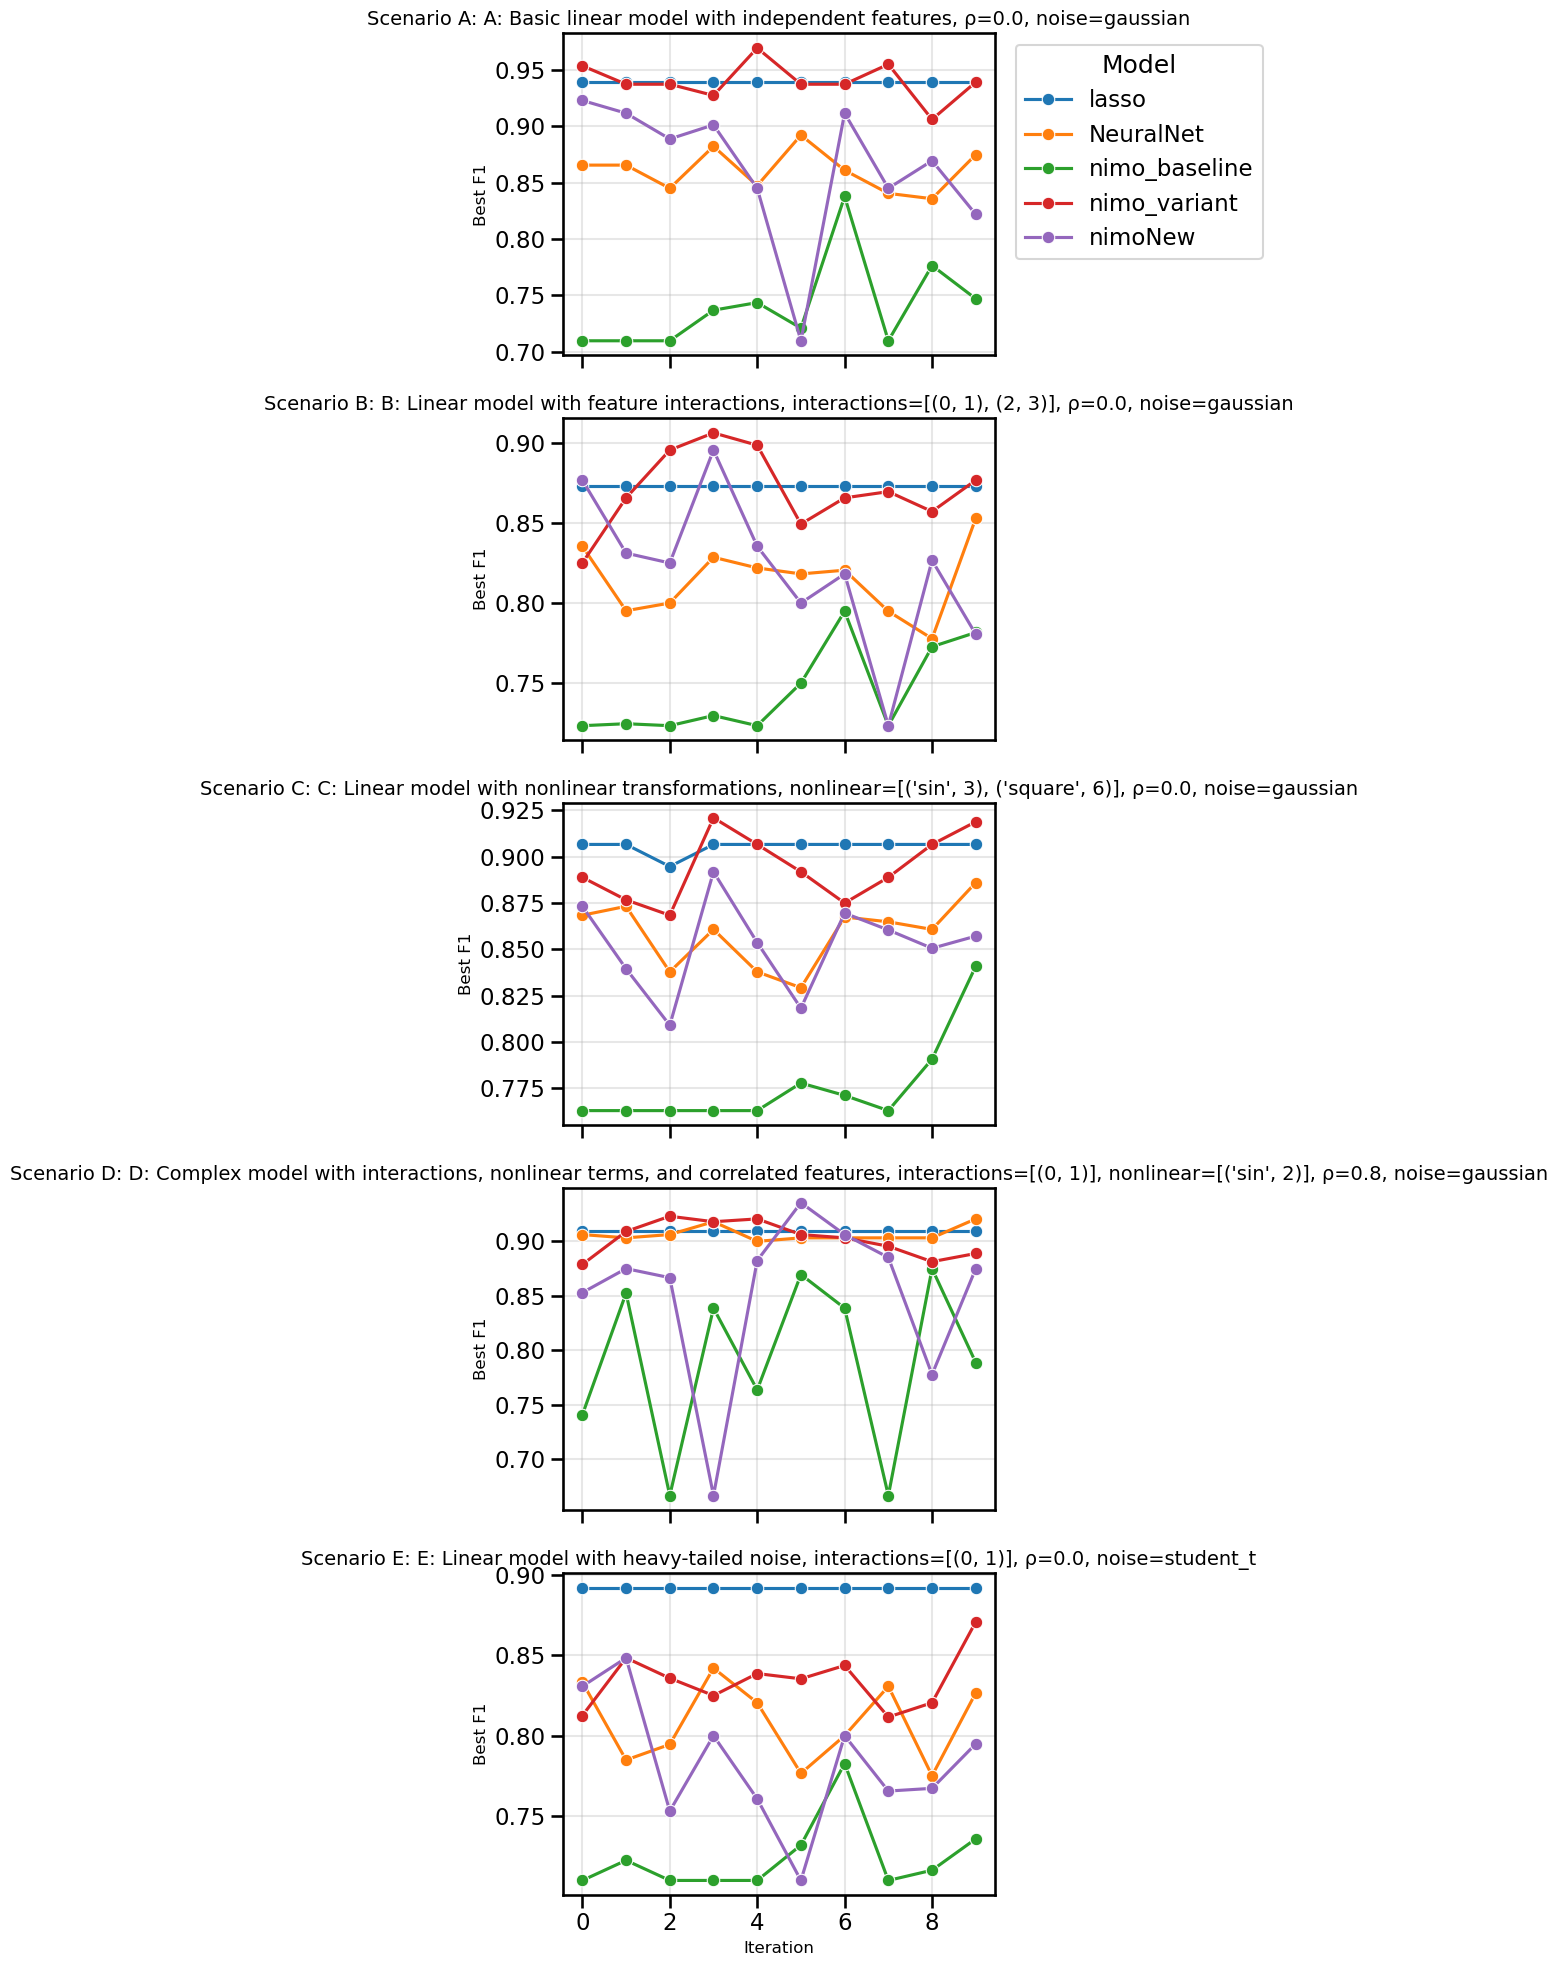

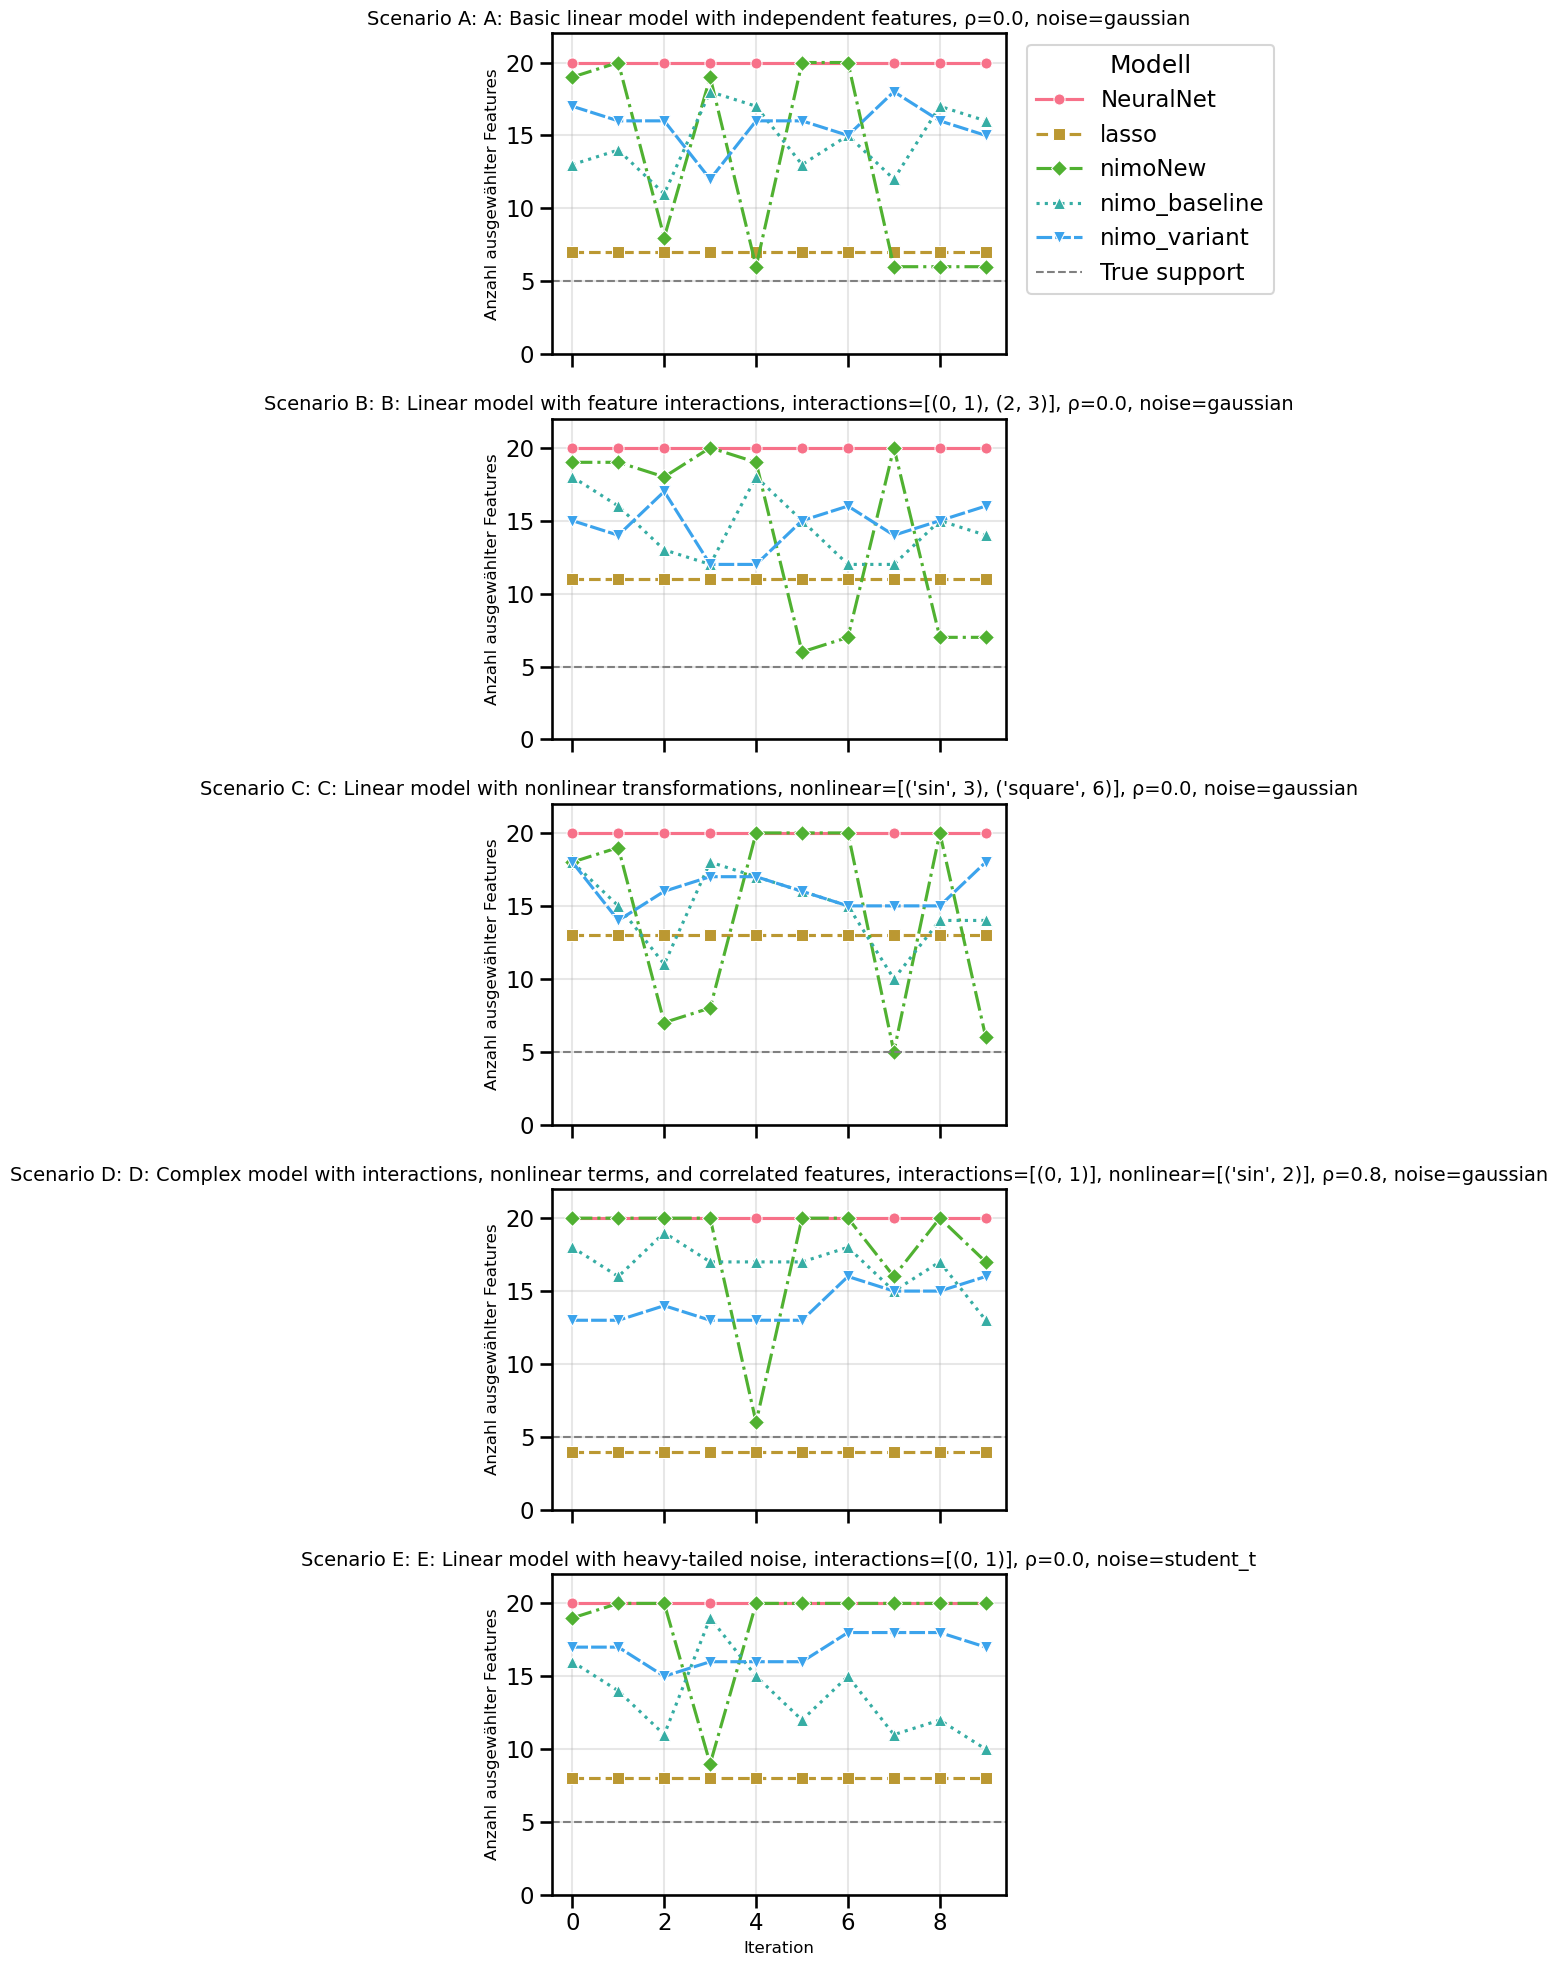

/var/folders/nm/wffg_5x13dv69w58yk8x6vhc0000gn/T/ipykernel_10499/3068437405.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


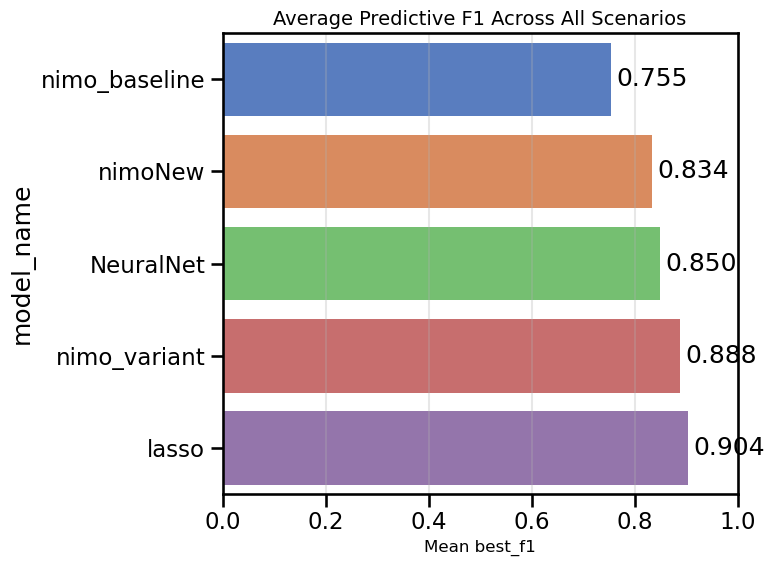

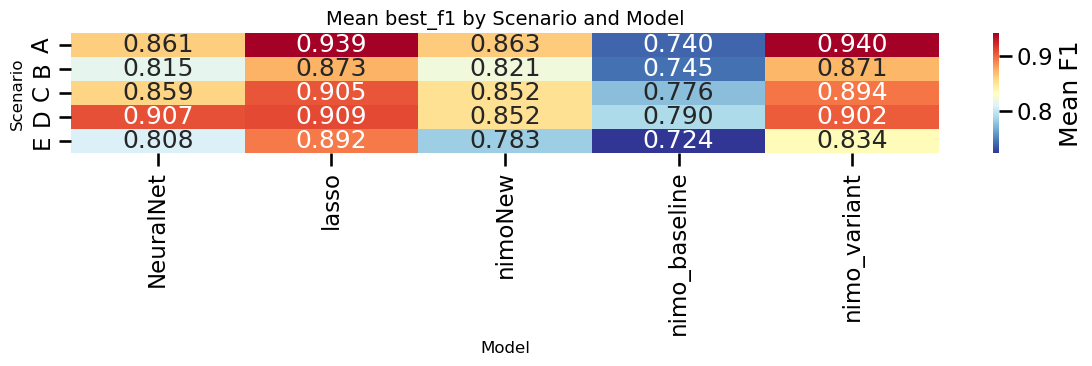

In [39]:
import pandas as pd
import ast, json
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

# -------------------------------
# 1) Daten einlesen & vorbereiten
# -------------------------------
df = pd.read_csv('../results/synthetic/all_model_results_synthetic.csv')
if 'error' in df.columns:
    df = df[df['error'].isna()].reset_index(drop=True)

# Parse selected_features aus String-JSON
df['selected_features'] = (
    df['selected_features']
      .fillna('[]')
      .apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else [])
)
# n_selected berechnen
df['n_selected'] = df['selected_features'].apply(len)

# numerische Spalten casten
for col in ['best_f1','f1_recovery','n_true_features']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Mapping Szenario → Beschreibung
desc_map = df.groupby('scenario')['scenario_description'].first().to_dict()
scenarios = sorted(df['scenario'].unique())
methods   = sorted(df['model_name'].unique())

linestyles = ['-', '--', '-.', ':', (0, (5,1))]
markers    = ['o', 's', 'D', '^', 'v']

# -------------------------------
# 2) Best‐F1 Score pro Scenario
# -------------------------------
fig, axes = plt.subplots(len(scenarios), 1,
                         figsize=(10, 4*len(scenarios)),
                         sharex=True)

for ax, scen in zip(axes, scenarios):
    grp = df[df['scenario']==scen]
    sns.lineplot(
        data=grp, x='iteration', y='best_f1',
        hue='model_name', marker='o',
        ax=ax,
        palette="tab10"
    )
    # Titel mit Beschreibung
    ax.set_title(f"Scenario {scen}: {desc_map.get(scen,'')}", fontsize=14)
    ax.set_ylabel("Best F1", fontsize=12)
    ax.grid(alpha=0.3)
    if ax is axes[0]:
        ax.legend(title="Model", bbox_to_anchor=(1.02,1), loc='upper left')
    else:
        ax.get_legend().remove()

axes[-1].set_xlabel("Iteration", fontsize=12)
fig.tight_layout(rect=(0,0,0.85,1))
plt.show()


# ---------------------------------------
# 3) Feature‑Count pro Scenario
# ---------------------------------------
# y‑Achse bis zum Maximum+2 extendieren
ylim_upper = df['n_selected'].max()
if 'n_true_features' in df.columns:
    ylim_upper = max(ylim_upper, df['n_true_features'].max())
ylim_upper += 2

fig, axes = plt.subplots(len(scenarios), 1,
                         figsize=(10, 4*len(scenarios)),
                         sharex=True)

for ax, scen in zip(axes, scenarios):
    grp = df[df['scenario']==scen]
    for i, method in enumerate(methods):
        sub = grp[grp['model_name']==method]
        if sub.empty:
            continue
        sns.lineplot(
            x='iteration', y='n_selected', data=sub,
            ax=ax,
            label=method,
            linestyle=linestyles[i % len(linestyles)],
            marker=markers[i % len(markers)],
            markersize=8
        )
    # True‑Support‑Linie
    if 'n_true_features' in grp.columns:
        ax.axhline(
            grp['n_true_features'].iloc[0],
            ls='--', color='gray',
            linewidth=1.5, label='True support'
        )
    ax.set_title(f"Scenario {scen}: {desc_map.get(scen,'')}", fontsize=14)
    ax.set_ylabel("Anzahl ausgewählter Features", fontsize=12)
    ax.set_ylim(0, ylim_upper)
    ax.grid(alpha=0.3)
    if ax is axes[0]:
        ax.legend(bbox_to_anchor=(1.02,1), loc='upper left', title="Modell")
    else:
        ax.get_legend().remove()

axes[-1].set_xlabel("Iteration", fontsize=12)
fig.tight_layout(rect=(0,0,0.85,1))
plt.show()


# --- 3) Average F1 Barplot ---
avg_f1 = df.groupby('model_name')['best_f1'].mean().sort_values()
plt.figure(figsize=(8, 6))
sns.barplot(
    x=avg_f1.values,
    y=avg_f1.index,
    palette="muted"
)
for i, (val, lab) in enumerate(zip(avg_f1.values, avg_f1.index)):
    plt.text(val + 0.01, i, f"{val:.3f}", va='center')
plt.title("Average Predictive F1 Across All Scenarios", fontsize=14)
plt.xlabel("Mean best_f1", fontsize=12)
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4) Predictive F1 Heatmap (mean best_f1) ---


# Pivot-Tabelle wie gehabt
heat_df = df.pivot_table(
    index='scenario',
    columns='model_name',
    values='best_f1',
    aggfunc='mean'
)

# Dynamische Min/Max-Werte
vmin = heat_df.values.min()
vmax = heat_df.values.max()

plt.figure(figsize=(12, 4))
sns.heatmap(
    heat_df,
    annot=True,
    fmt=".3f",
    cmap="RdYlBu_r",     # Kontraststärkere Diverging-Palette
    vmin=vmin,           # Am Daten-Minimum ausrichten
    vmax=vmax,           # Am Daten-Maximum ausrichten
    cbar_kws={'label': 'Mean F1'}
)
plt.title("Mean best_f1 by Scenario and Model", fontsize=14)
plt.ylabel("Scenario", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.tight_layout()
plt.show()
